In [2]:
import pandas as pd
import datetime as dt
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from RandomForestForTimeSeriesRegressor import RandomForestForTimeSeriesRegressor, BLOCK_TYPES

In [3]:
dataset = pd.read_csv('finviz_dataset.csv')

In [4]:
dataset = dataset.dropna()
dataset = dataset.sort_values("Date")
dataset

Date Ticker    Open   Close    High      Low   Volume
743396   1209128400     SW   12.75   12.75   12.75   12.750      484
743397   1210165200     SW   13.10   13.10   13.10   13.100      230
743398   1213621200     SW    8.15    8.15    8.15    8.150     1000
743399   1216990800     SW    5.35    5.35    5.35    5.350      400
743400   1220014800     SW    6.70    6.70    6.70    6.700      200
...             ...    ...     ...     ...     ...      ...      ...
617813   1733234400    VMC  287.26  286.50  289.12  284.590   542397
899953   1733234400   ZBRA  408.61  406.40  409.73  404.676   304688
615302   1733234400   GEHC   82.48   82.57   83.06   82.034  2026504
817090   1733234400   NTAP  123.29  124.67  124.86  122.090  1764475
1225247  1733234400   AMTM   23.63   24.27   24.53   23.615  1419967

[1225248 rows x 7 columns]

In [5]:
def calculateFields(dataset):
    if 'Date' not in dataset:
        dataset['Date'] = dataset['date']
        dataset = dataset.drop(columns=["date"])
    if 'Adj Close' in dataset:
        dataset = dataset.drop(columns=['Adj Close'])
    if 'Adj Close' in dataset:
        dataset = dataset.drop(columns=['Adj_close'])
    dataset['Date'] = pd.to_datetime(dataset['Date'])
    dataset['DateOrdinal'] = dataset['Date'].map(dt.datetime.toordinal)
    dataset['average_price'] = dataset[['Low', 'High']].mean(axis=1)
    dataset = dataset.drop(columns=["Volume", "Close", "Open", "Low", "High"])
    dataset['DayOfWeek'] = dataset['Date'].dt.dayofweek
    dataset['Month'] = dataset['Date'].dt.month
    dataset['Year'] = dataset['Date'].dt.year
    dataset['DayOfYear'] = dataset['Date'].dt.dayofyear
    dataset['WeekOfYear'] = dataset['Date'].dt.isocalendar().week

    dataset['is_start_of_month'] = (dataset['Date'].dt.day == 1).astype(int)
    dataset['is_end_of_month'] = (dataset['Date'] == dataset['Date'] + pd.offsets.MonthEnd(0)).astype(int)
    dataset['quarter'] = dataset['Date'].dt.quarter
    def get_season(month):
        if month in [12, 1, 2]:
            return 0#'winter'
        elif month in [3, 4, 5]:
            return 1#'spring'
        elif month in [6, 7, 8]:
            return 2#'summer'
        else:
            return 3#'autumn'
    dataset['season'] = dataset['Month'].apply(get_season)
    dataset['SerieNumber'] = (dataset['Date'] - dataset['Date'].min()).dt.days + 1


    days_ago = 30

    dataset["price_30_days_ago"] = dataset["average_price"].shift(days_ago)
    dataset["price_180_days_ago"] = dataset["average_price"].shift(180)
    dataset["price_365_days_ago"] = dataset["average_price"].shift(365)


    dataset = dataset.dropna().reset_index(drop=True)
    if 'Symbol' in dataset:
        dataset['Symbol'] = pd.factorize(dataset.Symbol)[0]
    else:
        dataset['Symbol'] = pd.factorize(dataset.Ticker)[0]
        dataset = dataset.drop(columns=['Ticker'])

    return dataset

calculatedFields = ["DateOrdinal", "DayOfWeek", "Month", "Year", "DayOfYear", "WeekOfYear", "is_start_of_month", "is_end_of_month", "quarter",
                    "season", "SerieNumber", "price_30_days_ago", "price_180_days_ago", "price_365_days_ago", 'Symbol']
fieldsPrice = ["average_price"]

dataset["Date"] = pd.to_datetime(dataset["Date"], unit="s")
dataset = calculateFields(dataset)
dataset

Date  DateOrdinal  average_price  DayOfWeek  Month  \
0       2014-12-11 14:00:00       735578        42.2405          3     12   
1       2014-12-11 14:00:00       735578        43.4500          3     12   
2       2014-12-11 14:00:00       735578        46.4665          3     12   
3       2014-12-11 14:00:00       735578        51.2245          3     12   
4       2014-12-11 14:00:00       735578         9.5785          3     12   
...                     ...          ...            ...        ...    ...   
1224878 2024-12-03 14:00:00       739223       286.8550          1     12   
1224879 2024-12-03 14:00:00       739223       407.2030          1     12   
1224880 2024-12-03 14:00:00       739223        82.5470          1     12   
1224881 2024-12-03 14:00:00       739223       123.4750          1     12   
1224882 2024-12-03 14:00:00       739223        24.0725          1     12   

         Year  DayOfYear  WeekOfYear  is_start_of_month  is_end_of_month  \
0        2014        345          50                  0                0   
1        2014        345          50                  0                0   
2        2014        345          50                  0                0   
3        2014        345          50                  0                0   
4        2014        345          50                  0                0   
...       ...        ...         ...                ...              ...   
1224878  2024        338          49                  0                0   
1224879  2024        338          49                  0                0   
1224880  2024        338          49                  0                0   
1224881  2024        338          49                  0                0   
1224882  2024        338          49                  0                0   

         quarter  season  SerieNumber  price_30_days_ago  price_180_days_ago  \
0              4       0         2422            68.1440             16.4000   
1              4       0         2422            29.4670             16.2500   
2              4       0         2422            20.2400             16.4500   
3              4       0         2422           107.8600             17.1300   
4              4       0         2422            59.9165             15.4950   
...          ...     ...          ...                ...                 ...   
1224878        4       0         6067           304.9250            348.7475   
1224879        4       0         6067           162.2450             52.3575   
1224880        4       0         6067           203.1450             30.8850   
1224881        4       0         6067           303.2300             62.4100   
1224882        4       0         6067            35.5150            159.0700   

         price_365_days_ago  Symbol  
0                    12.750       0  
1                    13.100       1  
2                     8.150       2  
3                     5.350       3  
4                     6.700       4  
...                     ...     ...  
1224878             118.520     256  
1224879             136.155      92  
1224880              13.105     497  
1224881             135.445       0  
1224882             384.990     502  

[1224883 rows x 17 columns]

In [6]:
dataset['Symbol'] = pd.factorize(dataset.Symbol)[0]

In [7]:
trainPercent = 80
trainSamples = (len(dataset.index) // 100) * trainPercent
testSamples = len(dataset.index) - trainSamples

In [8]:
def getRandomBlock(dataset0, blockDayRange):
    max_date = pd.to_datetime(dataset0['Date'].max())
    min_valid_date = max_date - pd.DateOffset(years=1)  # Fecha máxima menos un año
    
    valid_dates = dataset0[dataset0['Date'] <= min_valid_date]['Date']
    if valid_dates.empty:
        raise ValueError("No hay fechas válidas en el rango permitido.")
    
    random_start_date = np.random.choice(valid_dates)
    end_date = random_start_date + pd.DateOffset(days=blockDayRange)
    
    filtered_df = dataset0[(dataset0['Date'] >= random_start_date) & (dataset0['Date'] <= end_date)]
    return filtered_df

In [9]:
def getRandomTrainTestData(dataset0, daysRange, trainDays):
    blockDf = getRandomBlock(dataset0, daysRange)
    min_date = pd.to_datetime(dataset0['Date'].min())
    train_max_day = min_date + pd.DateOffset(days=trainDays)
    trainSamples = dataset0[dataset0['Date'] < train_max_day].shape[0]
    testSamples = len(dataset0.index) - trainSamples

    aux = dataset0.copy()
    aux = aux.drop("Date", axis=1)
    X = aux[calculatedFields].copy()
    aux = aux.drop(calculatedFields, axis=1)

    Y = aux.copy()

    X_train = X.iloc[:trainSamples]
    Y_train = Y.iloc[:trainSamples]
    X_test = X.iloc[-testSamples:]
    Y_test = Y.iloc[-testSamples:]

    return X_train, Y_train, X_test, Y_test

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

basicRFPrecision = []
for i in range(50):
    X_train0, Y_train0, X_test0, Y_test0 = getRandomTrainTestData(dataset, 730, 365)
    basicRF = RandomForestRegressor(n_jobs=5, n_estimators=100, max_depth=10)
    basicRF.fit(X_train0, Y_train0)
    y_pred = basicRF.predict(X_test0)
    rmse0 = sqrt(mean_squared_error(Y_test0, y_pred))
    print(f"RMSE:")
    print(rmse0)
    basicRFPrecision.append(rmse0)

c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
197.91809240326782


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
198.1387096523055


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
198.16289157731657


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
197.94565515567132


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
197.98033990508384


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
198.1164470957121


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
198.02608281767596


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
198.13815824153875


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
198.2570062187481


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
198.01783877530596


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
198.1589165275743


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
198.11600913538092


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
197.82297179344775


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
198.03392168681216


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
197.83274423416432


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
198.24017236663948


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
197.85754580888783


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
197.97643482299466


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
198.1195771466229


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
198.32198990903015


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
198.14417680128363


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
197.93195551780602


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
198.23576498980336


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
197.91105825990533


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
198.05816801821808


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
198.1867975372743


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
198.0612580596377


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
197.95594662177987


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
197.83285469697427


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
198.10177635888425


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
198.1225291537097


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
198.0369154256789


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
197.81522283474348


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
198.1596921849541


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
197.87044102434484


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
197.9875122678408


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
198.03978148156588


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
198.04365450116592


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
198.08619736681035


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
198.13965149990239


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
197.79398225705103


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
198.26505941307596


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
197.87621998901167


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
198.0131339540275


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
197.99510060804272


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
198.07147254703753


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
198.13290748959065


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
198.14744598700176


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
198.0147952063245


c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE:
197.9558322152355


In [11]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [12]:
daysOfBlocks = 730
daysOfTraining = 365
X_train0, Y_train0, X_test0, Y_test0 = getRandomTrainTestData(dataset, daysOfBlocks, daysOfTraining)
totalSamplesAprox = X_train0.shape[0]
blockSizes = [totalSamplesAprox / 100, totalSamplesAprox / 50, totalSamplesAprox / 25, totalSamplesAprox / 10, totalSamplesAprox / 5]
for i in range(len(blockSizes)):
    blockSizes[i] = int(blockSizes[i])


In [13]:
def testRftsAndGetRmseByAlgorithm(dataset0, daysOfBlocks0, daysOfTraining0, block_size0, algorithm0):
    X_train0, Y_train0, X_test0, Y_test0 = getRandomTrainTestData(dataset0, daysOfBlocks0, daysOfTraining0)
    rfts = RandomForestForTimeSeriesRegressor(n_jobs=5, n_estimators=100, block_size=block_size0, max_depth=10, block_type=BLOCK_TYPES[algorithm0])
    rfts.fit(X_train0, Y_train0)
    y_pred = rfts.predict(X_test0)
    rmse0 = sqrt(mean_squared_error(Y_test0, y_pred))
    return rmse0

In [14]:
precisionNonOverlapping = dict()
for block_size in blockSizes:
    precisionNonOverlapping[block_size] = []
    for k in range(50):
        rmse0 = testRftsAndGetRmseByAlgorithm(dataset, daysOfBlocks, daysOfTraining, block_size, 0)
        print(f"RMSE: ({block_size}, {k})")
        print(rmse0)
        precisionNonOverlapping[block_size].append(rmse0)

--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 0)
198.03706028669987


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 1)
198.12947986996315


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 2)
198.03028238251076


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 3)
197.9885269247317


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 4)
198.11091612028034


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 5)
197.92490491218098


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 6)
198.24613392044824


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 7)
198.14027523102436


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 8)
198.24391644895437


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 9)
197.88163467363432


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 10)
198.08191507063447


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 11)
198.1431437285725


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 12)
198.07679776073658


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 13)
197.89989445127978


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 14)
197.95810543007482


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 15)
197.93925038003255


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 16)
197.91459062491583


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 17)
198.0366975100894


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 18)
198.21026669608176


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 19)
198.17631823299868


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 20)
197.90686972243472


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 21)
198.08132370464884


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 22)
197.9898234309055


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 23)
197.8864207870509


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 24)
198.1073475627153


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 25)
198.10665362415017


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 26)
198.30736237088146


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 27)
197.98981523398635


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 28)
197.97483622083533


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 29)
198.08094566598265


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 30)
198.1070500027059


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 31)
198.05753643119144


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 32)
198.3135474203571


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 33)
198.00727124590034


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 34)
198.31547887933434


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 35)
198.10129617681963


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 36)
198.2284896271999


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 37)
197.89322647160913


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 38)
198.11779883760533


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 39)
198.25948657045325


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 40)
198.1104491254054


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 41)
198.2081520280546


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 42)
197.87806396284375


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 43)
198.08671305177856


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 44)
198.19582562314693


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 45)
197.93863116207328


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 46)
198.02630739083943


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 47)
198.12363909492117


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 48)
198.04372342288465


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 49)
198.32748075048596


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 0)
198.54819589842774


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 1)
198.25223975557006


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 2)
198.3061247512164


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 3)
198.08176116877448


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 4)
198.4947339400373


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 5)
198.3840748628675


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 6)
198.06698407028895


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 7)
198.0531833388626


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 8)
198.37548085502226


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 9)
198.33001409808355


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 10)
198.25738414392384


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 11)
198.1931894601267


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 12)
198.19253002191965


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 13)
198.0683615219879


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 14)
198.22606016643954


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 15)
198.01561708088846


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 16)
198.10993213301066


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 17)
198.4461731849776


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 18)
198.08772460254696


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 19)
198.22427773578224


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 20)
198.15816734949803


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 21)
198.20554403277882


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 22)
198.47867430398802


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 23)
198.4458654114143


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 24)
198.23476714361587


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 25)
198.303627548397


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 26)
198.17061362089518


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 27)
198.0275964838183


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 28)
198.1663394600306


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 29)
198.26887611922075


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 30)
198.55969691070482


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 31)
198.5161756860753


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 32)
198.3067476372754


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 33)
198.31241058761336


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 34)
198.28448507066278


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 35)
198.42266136018014


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 36)
198.28824513513413


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 37)
197.9449014201929


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 38)
198.12765565734153


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 39)
198.12455540635642


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 40)
198.3295905829909


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 41)
198.22955649691667


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 42)
198.38939593379038


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 43)
198.2694900377498


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 44)
198.4563520368079


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 45)
198.0545003912347


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 46)
198.34997555345757


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 47)
198.11169039738536


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 48)
198.1414829245639


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 49)
198.23084932575526


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 0)
198.8897114123609


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 1)
198.80082056965603


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 2)
198.62688987427794


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 3)
198.95423600745386


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 4)
198.6414073754941


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 5)
198.59507474496093


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 6)
198.8666725160975


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 7)
198.79320010097018


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 8)
198.5159182722055


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 9)
198.94028138164964


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 10)
198.66649701060177


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 11)
198.67665586625486


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 12)
199.10061224384467


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 13)
198.67754564092326


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 14)
198.8943851184176


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 15)
198.76048428083794


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 16)
198.5111650836895


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 17)
198.92524418388984


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 18)
198.73310084106592


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 19)
198.82094707662594


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 20)
198.7307188018733


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 21)
198.79824627414837


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 22)
198.74434258616657


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 23)
198.71012368048446


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 24)
198.5642984683843


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 25)
198.69458081067788


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 26)
198.6533129225373


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 27)
198.71402782011072


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 28)
199.03583498199833


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 29)
198.70745956777589


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 30)
198.88481991642615


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 31)
198.65765005113855


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 32)
199.06037346959457


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 33)
198.9976708509952


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 34)
199.07521291950502


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 35)
198.84097290247152


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 36)
198.6013464589501


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 37)
198.82613061605227


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 38)
198.77205535127842


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 39)
198.78476324689487


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 40)
199.00968796681533


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 41)
198.74105304022456


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 42)
198.59581064259675


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 43)
198.85412242135007


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 44)
198.74468116446337


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 45)
198.7306468358738


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 46)
198.54446170742514


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 47)
198.75259698510666


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 48)
198.6334924775725


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 49)
198.64386935762002


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 0)
199.62207232761523


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 1)
199.68543876226084


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 2)
199.47899907680215


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 3)
199.55653709377415


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 4)
199.60450773805925


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 5)
199.6910865296823


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 6)
199.8205901381067


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 7)
199.56282975072196


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 8)
199.51585296118748


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 9)
199.70555057951907


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 10)
199.86067663204295


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 11)
199.93892919674997


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 12)
199.68470231581108


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 13)
199.89317446808232


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 14)
199.68558895117397


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 15)
200.08050168352995


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 16)
199.94995113943608


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 17)
200.07780307509321


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 18)
199.4256048949882


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 19)
199.6791555809407


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 20)
199.77028039331032


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 21)
199.75628849944235


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 22)
199.52604230662203


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 23)
199.25304576827767


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 24)
199.62639054724386


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 25)
199.28737927824244


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 26)
199.93651134690998


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 27)
199.78169810796987


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 28)
199.54059777079482


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 29)
199.7508570142495


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 30)
199.65871235178435


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 31)
199.63031078258766


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 32)
199.6841153055495


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 33)
199.71601443203494


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 34)
199.74694309314705


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 35)
199.68943064083953


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 36)
199.50421270760125


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 37)
199.72175745701819


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 38)
199.72345392835092


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 39)
199.73943077863603


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 40)
199.5049589877705


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 41)
199.53210985121098


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 42)
199.7656388977131


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 43)
199.44644006935806


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 44)
199.48250976504337


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 45)
199.71906563299086


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 46)
199.7185132846155


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 47)
199.63326686089746


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 48)
200.00358384943388


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 49)
199.7187228887828


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 0)
200.55291769450616


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 1)
200.27252188588915


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 2)
200.53342309828147


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 3)
200.06515709043524


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 4)
200.6579779359641


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 5)
200.41190006104023


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 6)
200.27193529154349


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 7)
200.43475530539823


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 8)
200.21676596741656


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 9)
200.90622261239403


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 10)
200.00737046272647


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 11)
200.8812002172133


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 12)
200.4153490483671


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 13)
199.9993514999401


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 14)
200.142428997826


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 15)
200.36745576647346


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 16)
200.36643388245744


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 17)
200.5353200094234


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 18)
200.80728761435017


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 19)
200.18313147650036


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 20)
200.35186358221387


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 21)
200.2893809323563


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 22)
200.39026620327914


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 23)
200.2665842200139


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 24)
200.45907585393408


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 25)
200.662831392005


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 26)
200.61058674434705


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 27)
200.41913044855707


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 28)
200.39093170134063


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 29)
200.5393359943069


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 30)
200.65945500869822


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 31)
200.5351912249105


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 32)
200.191411852244


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 33)
200.35454271720002


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 34)
200.3835587214729


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 35)
200.45105468366933


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 36)
200.35435004887827


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 37)
200.18284636218272


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 38)
200.46357202090178


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 39)
200.45151810817126


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 40)
200.2326342961753


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 41)
200.22682839256046


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 42)
200.07042451230126


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 43)
200.2822622576671


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 44)
200.64326967094973


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 45)
200.43450090707708


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 46)
200.518120751432


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 47)
200.16964766671808


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 48)
200.36240819370153


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 49)
200.29705229189082


In [15]:
def getGraphData(presitionDataArray):
    all_arr = [basicRFPrecision]
    ticksIdx = [0]
    ticksNames = ["RF"]
    idx = 0
    for blockSize in blockSizes:
        
        data0 = []
        for r in presitionDataArray[blockSize]:
            data0.append(r)

        all_arr.append(data0)
        idx += 1
        ticksIdx.append(idx)
        ticksNames.append(str(blockSize))

    return all_arr, ticksIdx, ticksNames

Text(0, 0.5, 'RMSE')

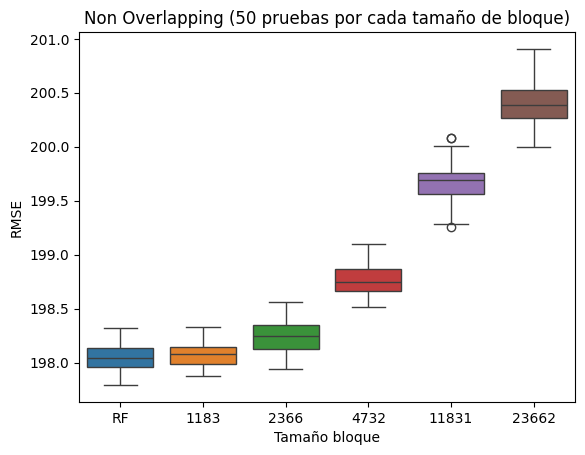

In [16]:
from matplotlib import pyplot as plt

all_arr, ticksIdx, ticksNames = getGraphData(precisionNonOverlapping)

sns.boxplot(data=all_arr)
plt.xticks(ticksIdx, ticksNames)
plt.title("Non Overlapping (50 pruebas por cada tamaño de bloque)")
plt.xlabel("Tamaño bloque")
plt.ylabel("RMSE")

In [17]:
precisionMovingBlock = dict()
for block_size in blockSizes:
    precisionMovingBlock[block_size] = []
    for k in range(50):
        rmse0 = testRftsAndGetRmseByAlgorithm(dataset, daysOfBlocks, daysOfTraining, block_size, 1)
        print(f"RMSE: ({block_size}, {k})")
        print(rmse0)
        precisionMovingBlock[block_size].append(rmse0)

--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 0)
198.27946944247608


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 1)
197.98959833069043


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 2)
198.19989952049872


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 3)
198.33511661568306


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 4)
198.4822898060803


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 5)
198.21501956608188


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 6)
198.47543301884684


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 7)
198.1930722149822


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 8)
198.51236337028334


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 9)
198.41039470345152


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 10)
198.18266270799484


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 11)
198.2141251878473


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 12)
198.15741183932772


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 13)
198.32629588578155


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 14)
198.2968286871266


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 15)
198.5382637310243


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 16)
198.31002552808823


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 17)
198.50203774735303


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 18)
198.4243337867027


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 19)
198.36100794511046


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 20)
198.24736535146218


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 21)
198.10818791348063


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 22)
198.2959911786528


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 23)
198.19148871036376


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 24)
198.29201662412868


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 25)
198.0695576683384


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 26)
198.49963741944654


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 27)
198.36025941313207


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 28)
198.21995783534985


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 29)
198.07481166550136


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 30)
198.23184750936045


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 31)
198.29928746985968


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 32)
198.30736522092604


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 33)
198.36851226778523


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 34)
198.22085428972997


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 35)
198.6936503906859


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 36)
198.35705164801874


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 37)
198.15428641923174


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 38)
198.1733721010174


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 39)
198.31146834636132


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 40)
198.09578595180952


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 41)
198.37345522551092


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 42)
198.4794710234134


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 43)
198.3503927155695


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 44)
198.34695744977392


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 45)
198.16410091191548


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 46)
198.26334194662095


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 47)
198.61819409874317


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 48)
198.27463924199427


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 49)
198.07915585064995


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 0)
198.3940634592173


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 1)
198.63847188511636


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 2)
198.46622856627613


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 3)
198.73928808688188


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 4)
198.65555355465236


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 5)
198.4092153095452


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 6)
198.58733599361287


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 7)
198.68806908639547


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 8)
198.6473365985689


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 9)
198.62822760913832


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 10)
198.32396435084223


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 11)
198.37388201284003


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 12)
198.51042991171872


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 13)
198.51682728798775


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 14)
198.50839016881835


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 15)
198.56536894538178


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 16)
198.46338168786062


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 17)
198.419482372362


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 18)
198.4579507825236


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 19)
198.3304960052471


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 20)
198.34758823548717


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 21)
198.40135238529354


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 22)
198.37366383564586


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 23)
198.36663951106166


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 24)
198.29604723579132


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 25)
198.25611493152425


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 26)
198.42395748141928


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 27)
198.46728179011214


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 28)
198.48645975778717


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 29)
198.39885915236124


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 30)
198.29632456573557


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 31)
198.50093820082176


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 32)
198.32203488409922


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 33)
198.48760443995846


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 34)
198.41557298423544


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 35)
198.1770437896933


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 36)
198.4567600448923


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 37)
198.4532326964036


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 38)
198.40987685939393


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 39)
198.51841775200586


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 40)
198.65195005007266


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 41)
198.4511620617778


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 42)
198.45231546931188


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 43)
198.36197377018482


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 44)
198.31206171169566


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 45)
198.5951481265759


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 46)
198.43041787980488


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 47)
198.35068091233245


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 48)
198.6565923737974


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 49)
198.64083290003265


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 0)
198.50822593614407


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 1)
198.4155108509396


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 2)
198.50800767756814


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 3)
198.72212360394616


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 4)
198.50959239300366


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 5)
198.8427223786732


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 6)
198.5869588491453


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 7)
198.5331414561825


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 8)
198.8637157686263


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 9)
198.5585229886684


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 10)
198.3940693189803


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 11)
198.51990268790442


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 12)
198.36486352688354


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 13)
198.71753720458926


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 14)
198.53845248682563


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 15)
198.45989150770268


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 16)
198.9052699758848


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 17)
199.0334048345196


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 18)
198.8200430846152


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 19)
198.48966785226295


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 20)
198.43448220978155


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 21)
198.68554979561372


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 22)
198.88473102817608


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 23)
198.68560415356765


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 24)
198.8569158894832


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 25)
198.65225798867928


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 26)
198.59223956608048


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 27)
198.7562892910932


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 28)
198.53403371701333


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 29)
198.74223575081098


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 30)
198.60543476570243


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 31)
198.8002129540686


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 32)
198.58099933756264


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 33)
198.7554995241998


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 34)
198.516577778285


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 35)
198.40281332245306


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 36)
198.6424063260598


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 37)
198.8559381834522


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 38)
198.7756146409659


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 39)
198.56338435377612


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 40)
198.6916285164807


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 41)
198.84097441156152


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 42)
198.51597268465093


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 43)
198.57631507833182


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 44)
198.52609079629556


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 45)
198.5991645510593


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 46)
198.49317325243146


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 47)
198.5576260695268


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 48)
198.96681014649977


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 49)
198.7523518530068


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 0)
198.9496765629497


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 1)
199.18006676713605


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 2)
199.19629359315752


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 3)
199.0178686156087


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 4)
199.17223600993177


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 5)
199.23518230235095


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 6)
199.33149642808021


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 7)
199.00724285345274


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 8)
199.0153659783685


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 9)
199.14596620334603


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 10)
199.52228753782077


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 11)
199.19203801050273


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 12)
198.99300472499473


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 13)
199.0013208228186


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 14)
199.09470392621645


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 15)
199.26767828765


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 16)
198.72222861518063


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 17)
198.99898765383617


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 18)
199.12112294405054


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 19)
199.321629266076


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 20)
199.4628596232926


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 21)
198.98047007978624


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 22)
199.0841965100816


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 23)
198.9853739579359


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 24)
199.1401301297649


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 25)
199.12498866824012


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 26)
199.3379300655783


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 27)
199.15641926163266


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 28)
198.96811883132


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 29)
199.40357198052206


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 30)
199.3054681152716


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 31)
199.3477882750591


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 32)
199.17476300966683


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 33)
199.48219692493714


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 34)
199.1672073524611


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 35)
199.1468127635201


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 36)
199.01593468225624


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 37)
199.48012359476894


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 38)
199.02284293886711


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 39)
199.3576105744809


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 40)
199.2144627596738


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 41)
199.28061603604968


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 42)
199.08924019656595


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 43)
199.51495948809452


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 44)
199.0722591226354


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 45)
198.66792249932914


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 46)
198.81661083075042


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 47)
199.30172377211946


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 48)
199.1418233890626


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 49)
199.07339074489096


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 0)
199.8889954366551


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 1)
200.4291682493843


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 2)
199.73561201172527


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 3)
200.2845446206594


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 4)
200.09021298455832


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 5)
200.04118350950006


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 6)
199.82572197698647


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 7)
199.99311416754145


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 8)
199.85078667795668


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 9)
200.1323978008959


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 10)
199.5256035847255


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 11)
199.5455081291214


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 12)
199.3809457080463


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 13)
199.65529476405524


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 14)
200.11557420517553


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 15)
199.8450894811442


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 16)
199.81107374299773


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 17)
199.62734632315755


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 18)
199.85216596863177


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 19)
199.48109871821882


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 20)
199.80924392465909


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 21)
199.39935243531127


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 22)
199.6199110033208


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 23)
199.7320763417498


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 24)
199.7506597552516


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 25)
199.57507957743474


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 26)
199.7006547548906


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 27)
200.17049446482895


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 28)
200.3419463293414


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 29)
199.70233244525818


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 30)
199.85830542347605


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 31)
199.69717654334048


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 32)
199.59682065742933


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 33)
200.2826937558497


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 34)
199.98559898441448


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 35)
200.20256029824307


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 36)
200.22880016175935


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 37)
199.74416722154646


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 38)
199.70116334574595


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 39)
199.76854061305545


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 40)
199.79016388235613


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 41)
199.49492602375324


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 42)
199.51614874913597


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 43)
200.26409555413557


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 44)
200.04099002499083


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 45)
200.1681010607717


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 46)
199.49373757100022


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 47)
200.03694751402304


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 48)
199.72053350145433


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 49)
199.8150674915526


Text(0, 0.5, 'RMSE')

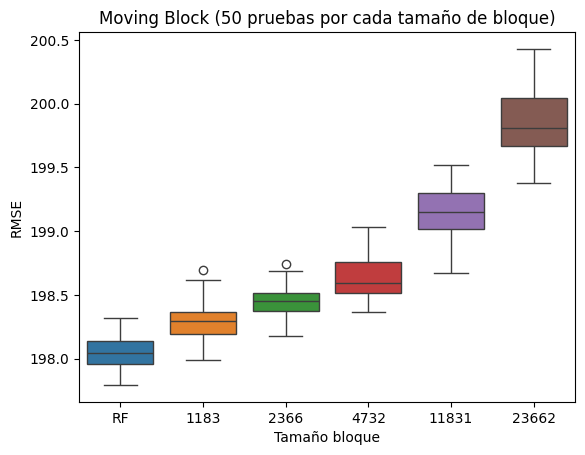

In [18]:
all_arr, ticksIdx, ticksNames = getGraphData(precisionMovingBlock)

sns.boxplot(data=all_arr)
plt.xticks(ticksIdx, ticksNames)
plt.title("Moving Block (50 pruebas por cada tamaño de bloque)")
plt.xlabel("Tamaño bloque")
plt.ylabel("RMSE")

In [19]:
precisionCircularBlock = dict()
for block_size in blockSizes:
    precisionCircularBlock[block_size] = []
    for k in range(50):
        rmse0 = testRftsAndGetRmseByAlgorithm(dataset, daysOfBlocks, daysOfTraining, block_size, 2)
        print(f"RMSE: ({block_size}, {k})")
        print(rmse0)
        precisionCircularBlock[block_size].append(rmse0)

--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 0)
198.1300110672843


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 1)
198.29236573011718


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 2)
198.18353007599833


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 3)
198.3584021781309


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 4)
198.1289182634748


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 5)
198.30174542760741


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 6)
198.4684629016657


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 7)
198.42887729672674


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 8)
198.28805836240699


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 9)
198.29141586771334


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 10)
198.39507537003715


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 11)
198.2305268882851


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 12)
198.32767872898012


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 13)
198.16936011173644


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 14)
198.47153864077376


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 15)
198.213246713244


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 16)
198.34456679564101


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 17)
198.22652486324353


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 18)
198.2570750553973


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 19)
198.21390360230578


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 20)
198.27210162673683


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 21)
198.29004996693303


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 22)
198.14748724960984


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 23)
198.3339091301197


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 24)
198.08555676029178


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 25)
198.57206572603886


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 26)
198.38494835135074


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 27)
198.40427786387866


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 28)
198.42677160547197


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 29)
198.55467168138748


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 30)
198.28316745842582


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 31)
198.33237995813417


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 32)
198.40016900965523


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 33)
198.4470992082054


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 34)
198.34952788774746


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 35)
198.20925760206086


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 36)
198.0852956751435


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 37)
198.18496143919606


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 38)
197.98645779792096


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 39)
198.36309237169414


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 40)
198.26822217107767


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 41)
198.5497751110159


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 42)
198.26245789488482


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 43)
198.27843537016886


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 44)
198.5438233411307


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 45)
198.18396119960434


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 46)
198.06603493084222


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 47)
198.36428509631176


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 48)
198.37195149729112


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (1183, 49)
198.28561091013893


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 0)
198.5050159189915


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 1)
198.26219109455076


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 2)
198.3144574564337


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 3)
198.28808938803692


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 4)
198.46453481919602


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 5)
198.4108818031512


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 6)
198.1868602966432


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 7)
198.5550472653722


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 8)
198.2185911501691


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 9)
198.4607921926952


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 10)
198.55660216285872


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 11)
198.47605834480805


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 12)
198.4712577585104


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 13)
198.51566621301907


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 14)
198.5117085779579


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 15)
198.48991098367577


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 16)
198.61004190383886


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 17)
198.59247488005323


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 18)
198.3851327074137


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 19)
198.41869540711897


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 20)
198.49639653663928


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 21)
198.38174205660516


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 22)
198.26479548919045


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 23)
198.56593249137526


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 24)
198.46494798725067


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 25)
198.54395171648667


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 26)
198.2660597216274


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 27)
198.34705805885648


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 28)
198.53127508404015


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 29)
198.37526522628724


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 30)
198.04035869704114


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 31)
198.31888981254403


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 32)
198.45642921222614


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 33)
198.22975446026464


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 34)
198.1344158200671


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 35)
198.44167546117527


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 36)
198.50802513670084


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 37)
198.55349068894716


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 38)
198.382329878233


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 39)
198.7651124715387


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 40)
198.6121098223831


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 41)
198.56745494680453


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 42)
198.7997612358602


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 43)
198.5388179581821


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 44)
198.48917468396


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 45)
198.29425023427765


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 46)
198.82104144274538


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 47)
198.5849570066596


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 48)
198.7121131203099


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (2366, 49)
198.5169513149296


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 0)
198.80495328282973


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 1)
198.4458291638679


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 2)
198.5631897354477


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 3)
198.7199616743261


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 4)
198.77584678852347


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 5)
198.67749159482324


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 6)
198.76819988929336


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 7)
198.74536577332435


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 8)
198.46586054666952


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 9)
198.77059499276905


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 10)
198.62364120452494


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 11)
198.63144615465436


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 12)
198.74139553380112


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 13)
198.6593989166883


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 14)
198.77088477466012


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 15)
198.64532121140226


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 16)
198.6285869729556


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 17)
198.58378697745368


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 18)
198.6855742401759


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 19)
198.4824903155848


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 20)
198.25742438399067


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 21)
198.42050152711778


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 22)
198.61598392309332


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 23)
198.4552456007835


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 24)
198.64823006146148


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 25)
198.6348879737256


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 26)
198.58340499175563


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 27)
198.541372160092


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 28)
198.65593678091602


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 29)
198.6536496620087


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 30)
198.48417391577843


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 31)
198.77266308771277


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 32)
198.83154147657663


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 33)
198.50690853291567


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 34)
198.72682222092075


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 35)
198.28185057379378


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 36)
198.7159924562769


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 37)
198.42697722544477


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 38)
198.75290343635922


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 39)
198.79624943226383


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 40)
198.67095851742488


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 41)
198.58564494774197


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 42)
198.42888457445486


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 43)
198.7447582512601


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 44)
198.57112239088727


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 45)
198.7040644594574


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 46)
198.6961979040371


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 47)
198.69690982983346


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 48)
198.52575437750778


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (4732, 49)
198.7829311740991


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 0)
198.8689602274191


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 1)
199.3629614078009


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 2)
199.28447781563293


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 3)
198.8769120711613


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 4)
199.39531617620503


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 5)
199.1082629148574


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 6)
199.32651952048502


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 7)
199.4957598605022


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 8)
198.9330870140027


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 9)
199.15394232976416


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 10)
199.34057901521427


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 11)
198.8913309501423


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 12)
199.2231767634658


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 13)
199.15451327104145


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 14)
198.94484723329398


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 15)
199.34764764099432


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 16)
199.0363208228497


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 17)
199.25833937900842


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 18)
198.94550208587137


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 19)
199.33922482241306


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 20)
199.39312467095039


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 21)
199.00348950230517


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 22)
199.1586022765364


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 23)
199.09736232068317


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 24)
199.35781031514534


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 25)
199.2270238938622


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 26)
199.51123715374294


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 27)
199.38790995822106


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 28)
198.91938405211545


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 29)
199.09602947475005


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 30)
199.3963562298738


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 31)
199.0909752066733


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 32)
199.31245825239506


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 33)
199.2625943826136


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 34)
198.91443711973318


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 35)
198.90434655455337


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 36)
199.34885600727495


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 37)
199.34031718135185


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 38)
199.33894501751516


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 39)
199.09222132108533


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 40)
198.9732911362213


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 41)
199.18932128596478


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 42)
199.07994081639364


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 43)
199.17297747812117


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 44)
199.12053400804172


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 45)
199.67926028245475


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 46)
199.1251635143358


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 47)
199.06956384314708


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 48)
199.06253301924008


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (11831, 49)
199.1044644987797


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 0)
199.79411275710902


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 1)
199.75177941353553


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 2)
200.02699592688379


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 3)
199.72156220224582


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 4)
199.753237852326


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 5)
199.369267381781


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 6)
199.8492815819808


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 7)
199.58680061484972


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 8)
199.36315747606022


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 9)
200.03461659390373


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 10)
200.0300042675596


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 11)
200.12938587191547


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 12)
199.9065672556159


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 13)
199.72109002355757


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 14)
199.87264564173284


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 15)
199.95964301327925


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 16)
200.02663201856902


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 17)
199.8128750225595


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 18)
200.0004647627313


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 19)
200.4018654526413


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 20)
199.922375871762


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 21)
199.93414033318322


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 22)
200.27509552805418


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 23)
199.88094192619135


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 24)
200.0662736535131


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 25)
200.11860633711677


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 26)
199.59016148176988


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 27)
199.71139966519573


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 28)
200.05790966933424


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 29)
200.12890761746735


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 30)
199.95837262123894


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 31)
200.11515031389732


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 32)
199.2087124489685


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 33)
200.47048118645014


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 34)
200.0925805932606


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 35)
199.94006535329603


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 36)
200.3098090969032


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 37)
199.81834579121826


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 38)
199.95485536298006


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 39)
200.13301387115925


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 40)
199.6683810268212


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 41)
200.1322410693651


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 42)
199.7396785948176


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 43)
200.05635605901347


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 44)
199.95888256342553


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 45)
199.6244006712958


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 46)
199.34051728836067


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 47)
199.65224117361996


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 48)
200.12491636452094


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c

RMSE: (23662, 49)
199.77874204133286


Text(0, 0.5, 'RMSE')

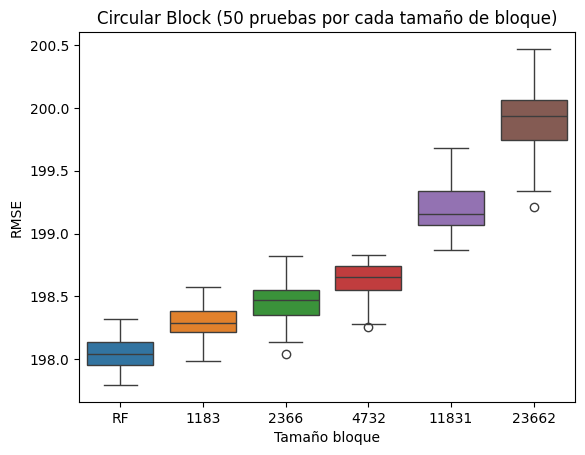

In [20]:
all_arr, ticksIdx, ticksNames = getGraphData(precisionCircularBlock)

sns.boxplot(data=all_arr)
plt.xticks(ticksIdx, ticksNames)
plt.title("Circular Block (50 pruebas por cada tamaño de bloque)")
plt.xlabel("Tamaño bloque")
plt.ylabel("RMSE")

Text(24.972222222222214, 0.5, 'RMSE')

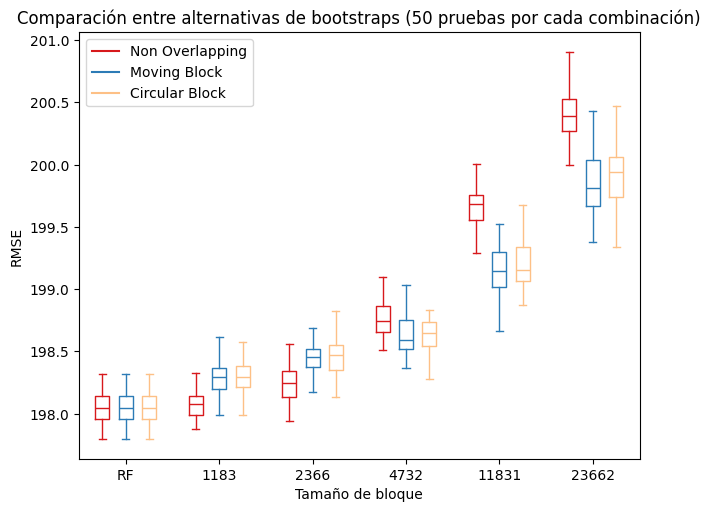

In [21]:
all_arr, ticksIdx, ticksNames = getGraphData(precisionNonOverlapping)
all_arr1, ticksIdx, ticksNames = getGraphData(precisionMovingBlock)
all_arr2, ticksIdx, ticksNames = getGraphData(precisionCircularBlock)

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()

bp0 = plt.boxplot(all_arr, positions=np.array(range(len(all_arr)))*2.0-0.5, sym='', widths=0.3)
bp1 = plt.boxplot(all_arr1, positions=np.array(range(len(all_arr1)))*2.0, sym='', widths=0.3)
bp2 = plt.boxplot(all_arr2, positions=np.array(range(len(all_arr1)))*2.0+0.5, sym='', widths=0.3)
set_box_color(bp0, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bp1, '#2C7BB6')
set_box_color(bp2, '#fdc086')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Non Overlapping')
plt.plot([], c='#2C7BB6', label='Moving Block')
plt.plot([], c='#fdc086', label='Circular Block')
plt.legend()

plt.xticks(range(0, len(ticksNames) * 2, 2), ticksNames)
# plt.xlim(-2, len(ticks)*2)
#plt.ylim(34, 55)
plt.tight_layout()
plt.title("Comparación entre alternativas de bootstraps (50 pruebas por cada combinación)")
plt.xlabel("Tamaño de bloque")
plt.ylabel("RMSE")